In [ ]:
!pip install pytorch_lightning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from collections import defaultdict

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

tqdm.pandas()

In [ ]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [ ]:
from google.colab import files
import io

uploaded = files.upload()

In [ ]:
df = pd.read_csv('./load_weather_programs_df.csv', parse_dates=['intervalStart'])
df.head()

,Unnamed: 0,intervalStart,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,cloudCover,dewPoint,...,windGust,windSpeed,DVR_duration_mins,CampusGen_duration_mins,CIGen_duration_mins,ACST_duration_mins,PTR_duration_mins,Interruptible Irrigation_duration_mins,Cycled Air Conditioning_duration_mins,Interruptible Water Heating_duration_mins
0,0,2017-01-01 01:00:00,194634.4219,1.483254e+09,45.395556,-93.386667,0.0,18.93,0.39,19.23,...,10.51,5.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2017-01-01 02:00:00,185003.5234,1.483258e+09,45.395556,-93.386667,0.0,20.16,0.00,18.98,...,8.88,4.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2017-01-01 03:00:00,179523.5938,1.483261e+09,45.395556,-93.386667,0.0,20.40,0.04,18.58,...,6.34,3.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2017-01-01 04:00:00,178223.6797,1.483265e+09,45.395556,-93.386667,0.0,24.46,0.20,18.62,...,5.83,2.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2017-01-01 05:00:00,180018.2031,1.483268e+09,45.395556,-93.386667,0.0,23.61,0.11,18.69,...,3.13,1.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# import io

# df = pd.read_csv(io.BytesIO(uploaded['load_weather_programs_df.csv']), parse_dates=['intervalStart'])
# df.head()

In [ ]:
df.shape

(58634, 33)

### Preprocessing

In [ ]:
df['prev_Connexus_kWh'] = df.shift(1)['Connexus_kWh']

In [ ]:
df['Connexus_kWh_change'] = df.progress_apply(
    lambda row : 0 if np.isnan(row.prev_Connexus_kWh) else (row.Connexus_kWh - row.prev_Connexus_kWh),
    axis=1
)

  0%|          | 0/58634 [00:00<?, ?it/s]

In [ ]:
df.head()

,Unnamed: 0,intervalStart,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,cloudCover,dewPoint,...,DVR_duration_mins,CampusGen_duration_mins,CIGen_duration_mins,ACST_duration_mins,PTR_duration_mins,Interruptible Irrigation_duration_mins,Cycled Air Conditioning_duration_mins,Interruptible Water Heating_duration_mins,prev_Connexus_kWh,Connexus_kWh_change
0,0,2017-01-01 01:00:00,194634.4219,1.483254e+09,45.395556,-93.386667,0.0,18.93,0.39,19.23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0000
1,1,2017-01-01 02:00:00,185003.5234,1.483258e+09,45.395556,-93.386667,0.0,20.16,0.00,18.98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,194634.4219,-9630.8985
2,2,2017-01-01 03:00:00,179523.5938,1.483261e+09,45.395556,-93.386667,0.0,20.40,0.04,18.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185003.5234,-5479.9296
3,3,2017-01-01 04:00:00,178223.6797,1.483265e+09,45.395556,-93.386667,0.0,24.46,0.20,18.62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179523.5938,-1299.9141
4,4,2017-01-01 05:00:00,180018.2031,1.483268e+09,45.395556,-93.386667,0.0,23.61,0.11,18.69,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,178223.6797,1794.5234


In [ ]:
df.columns

Index(['Unnamed: 0', 'intervalStart', 'Connexus_kWh', 'unixTime', 'latitude',
       'longitude', 'station', 'apparentTemperature', 'cloudCover', 'dewPoint',
       'humidity', 'icon', 'precipAccumulation', 'precipIntensity',
       'precipProbability', 'precipType', 'pressure', 'snowAccumulation',
       'snowIntensity', 'temperature', 'uvIndex', 'visibility', 'windBearing',
       'windGust', 'windSpeed', 'DVR_duration_mins', 'CampusGen_duration_mins',
       'CIGen_duration_mins', 'ACST_duration_mins', 'PTR_duration_mins',
       'Interruptible Irrigation_duration_mins',
       'Cycled Air Conditioning_duration_mins',
       'Interruptible Water Heating_duration_mins', 'prev_Connexus_kWh',
       'Connexus_kWh_change'],
      dtype='object')

In [ ]:
rows = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
  row_data = dict()

  for column in df.columns:
    if column == 'intervalStart':
      row_data['day_of_week'] = row.intervalStart.dayofweek
      row_data['day_of_month'] = row.intervalStart.day
      row_data['week_of_year'] = row.intervalStart.week
      row_data['month'] = row.intervalStart.month

    else:
      if column!='prev_Connexus_kWh':
        row_data[str(column)] = row[str(column)]


  rows.append(row_data)

features_df = pd.DataFrame(rows)
features_df.head()

  0%|          | 0/58634 [00:00<?, ?it/s]

,Unnamed: 0,day_of_week,day_of_month,week_of_year,month,Connexus_kWh,unixTime,latitude,longitude,station,...,windSpeed,DVR_duration_mins,CampusGen_duration_mins,CIGen_duration_mins,ACST_duration_mins,PTR_duration_mins,Interruptible Irrigation_duration_mins,Cycled Air Conditioning_duration_mins,Interruptible Water Heating_duration_mins,Connexus_kWh_change
0,0,6,1,52,1,194634.4219,1.483254e+09,45.395556,-93.386667,0.0,...,5.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
1,1,6,1,52,1,185003.5234,1.483258e+09,45.395556,-93.386667,0.0,...,4.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9630.8985
2,2,6,1,52,1,179523.5938,1.483261e+09,45.395556,-93.386667,0.0,...,3.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5479.9296
3,3,6,1,52,1,178223.6797,1.483265e+09,45.395556,-93.386667,0.0,...,2.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1299.9141
4,4,6,1,52,1,180018.2031,1.483268e+09,45.395556,-93.386667,0.0,...,1.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1794.5234


In [ ]:
features_df = features_df.drop(['Unnamed: 0'], axis=1)
features_df.shape

(58634, 36)

In [ ]:
train_size = int(len(features_df)*0.9)
train_size

52770

In [ ]:
train_df, test_df = features_df[:train_size], features_df[train_size+1:]
train_df.shape, test_df.shape


((52770, 36), (5863, 36))

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_df)

In [ ]:
train_df = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=train_df.index)
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

In [ ]:
train_df.head()

,day_of_week,day_of_month,week_of_year,month,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,...,windSpeed,DVR_duration_mins,CampusGen_duration_mins,CIGen_duration_mins,ACST_duration_mins,PTR_duration_mins,Interruptible Irrigation_duration_mins,Cycled Air Conditioning_duration_mins,Interruptible Water Heating_duration_mins,Connexus_kWh_change
0,1.0,-1.0,0.961538,-1.0,-0.686765,-1.000000,-1.0,-1.0,-1.0,-0.110541,...,-0.629980,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.201370
1,1.0,-1.0,0.961538,-1.0,-0.733464,-0.999962,-1.0,-1.0,-1.0,-0.094758,...,-0.702903,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.068010
2,1.0,-1.0,0.961538,-1.0,-0.760036,-0.999925,-1.0,-1.0,-1.0,-0.091679,...,-0.757596,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.125489
3,1.0,-1.0,0.961538,-1.0,-0.766339,-0.999887,-1.0,-1.0,-1.0,-0.039584,...,-0.805537,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183370
4,1.0,-1.0,0.961538,-1.0,-0.757638,-0.999849,-1.0,-1.0,-1.0,-0.050491,...,-0.887914,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.226219


In [ ]:
test_df.head()

,day_of_week,day_of_month,week_of_year,month,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,...,windSpeed,DVR_duration_mins,CampusGen_duration_mins,CIGen_duration_mins,ACST_duration_mins,PTR_duration_mins,Interruptible Irrigation_duration_mins,Cycled Air Conditioning_duration_mins,Interruptible Water Heating_duration_mins,Connexus_kWh_change
52771,-1.0,0.466667,-0.884615,-1.0,-0.348346,1.000075,-1.0,-1.0,-1.0,-0.373067,...,-0.367319,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.408625
52772,-1.0,0.466667,-0.884615,-1.0,-0.352196,1.000113,-1.0,-1.0,-1.0,-0.373067,...,-0.414585,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.190375
52773,-1.0,0.466667,-0.884615,-1.0,-0.343942,1.000151,-1.0,-1.0,-1.0,-0.377302,...,-0.272789,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.224942
52774,-1.0,0.466667,-0.884615,-1.0,-0.326570,1.000188,-1.0,-1.0,-1.0,-0.344069,...,-0.216745,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.250981
52775,-1.0,0.466667,-0.884615,-1.0,-0.325773,1.000226,-1.0,-1.0,-1.0,-0.254635,...,-0.395679,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.203646


In [ ]:
for i in train_df.columns:
  if '_mins' in i:
    train_df = train_df.drop(columns = [i])


for i in test_df.columns:
  if '_mins' in i:
    test_df = test_df.drop(columns = [i])

In [ ]:
train_df.columns

Index(['day_of_week', 'day_of_month', 'week_of_year', 'month', 'Connexus_kWh',
       'unixTime', 'latitude', 'longitude', 'station', 'apparentTemperature',
       'cloudCover', 'dewPoint', 'humidity', 'icon', 'precipAccumulation',
       'precipIntensity', 'precipProbability', 'precipType', 'pressure',
       'snowAccumulation', 'snowIntensity', 'temperature', 'uvIndex',
       'visibility', 'windBearing', 'windGust', 'windSpeed',
       'Connexus_kWh_change'],
      dtype='object')

In [ ]:
test_df.columns


Index(['day_of_week', 'day_of_month', 'week_of_year', 'month', 'Connexus_kWh',
       'unixTime', 'latitude', 'longitude', 'station', 'apparentTemperature',
       'cloudCover', 'dewPoint', 'humidity', 'icon', 'precipAccumulation',
       'precipIntensity', 'precipProbability', 'precipType', 'pressure',
       'snowAccumulation', 'snowIntensity', 'temperature', 'uvIndex',
       'visibility', 'windBearing', 'windGust', 'windSpeed',
       'Connexus_kWh_change'],
      dtype='object')

In [ ]:
def create_sequences(input_data:pd.DataFrame, target_column, sequence_length):

  sequences = []
  data_size = len(input_data)

  for i in  tqdm(range(data_size - sequence_length)):
    sequence = input_data[i:i+sequence_length]

    label_position = i + sequence_length
    label = input_data.iloc[label_position][target_column]


    sequences.append((sequence, label))

  return sequences


In [ ]:
sequence_length = 120

train_sequences = create_sequences(train_df, 'Connexus_kWh', sequence_length)
test_sequences = create_sequences(test_df, 'Connexus_kWh', sequence_length)


  0%|          | 0/52650 [00:00<?, ?it/s]

  0%|          | 0/5743 [00:00<?, ?it/s]

In [ ]:
train_sequences[0][0].head()

,day_of_week,day_of_month,week_of_year,month,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,...,pressure,snowAccumulation,snowIntensity,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,Connexus_kWh_change
0,1.0,-1.0,0.961538,-1.0,-0.686765,-1.000000,-1.0,-1.0,-1.0,-0.110541,...,-0.163265,-1.0,-1.0,-0.121193,-1.0,1.0,0.247911,-0.576466,-0.629980,0.201370
1,1.0,-1.0,0.961538,-1.0,-0.733464,-0.999962,-1.0,-1.0,-1.0,-0.094758,...,-0.142857,-1.0,-1.0,-0.120117,-1.0,1.0,0.286908,-0.642152,-0.702903,0.068010
2,1.0,-1.0,0.961538,-1.0,-0.760036,-0.999925,-1.0,-1.0,-1.0,-0.091679,...,-0.122449,-1.0,-1.0,-0.130268,-1.0,1.0,0.309192,-0.744509,-0.757596,0.125489
3,1.0,-1.0,0.961538,-1.0,-0.766339,-0.999887,-1.0,-1.0,-1.0,-0.039584,...,-0.102041,-1.0,-1.0,-0.136881,-1.0,1.0,0.364903,-0.765061,-0.805537,0.183370
4,1.0,-1.0,0.961538,-1.0,-0.757638,-0.999849,-1.0,-1.0,-1.0,-0.050491,...,-0.071429,-1.0,-1.0,-0.149954,-1.0,1.0,0.325905,-0.873867,-0.887914,0.226219


In [ ]:
test_sequences[0][0].head()

,day_of_week,day_of_month,week_of_year,month,Connexus_kWh,unixTime,latitude,longitude,station,apparentTemperature,...,pressure,snowAccumulation,snowIntensity,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,Connexus_kWh_change
52771,-1.0,0.466667,-0.884615,-1.0,-0.348346,1.000075,-1.0,-1.0,-1.0,-0.373067,...,-0.020408,-1.0,-1.0,-0.335743,-1.0,0.696,0.192201,-0.132380,-0.367319,0.408625
52772,-1.0,0.466667,-0.884615,-1.0,-0.352196,1.000113,-1.0,-1.0,-1.0,-0.373067,...,-0.010204,-1.0,-1.0,-0.344509,-1.0,0.914,0.192201,-0.245215,-0.414585,0.190375
52773,-1.0,0.466667,-0.884615,-1.0,-0.343942,1.000151,-1.0,-1.0,-1.0,-0.377302,...,-0.030612,-1.0,-1.0,-0.330667,-1.0,0.942,0.203343,-0.188797,-0.272789,0.224942
52774,-1.0,0.466667,-0.884615,-1.0,-0.326570,1.000188,-1.0,-1.0,-1.0,-0.344069,...,-0.040816,-1.0,-1.0,-0.294217,-1.0,0.928,0.348189,-0.250453,-0.216745,0.250981
52775,-1.0,0.466667,-0.884615,-1.0,-0.325773,1.000226,-1.0,-1.0,-1.0,-0.254635,...,-0.020408,-1.0,-1.0,-0.232082,-1.0,0.770,0.381616,-0.295587,-0.395679,0.203646


In [ ]:
len(train_sequences), len(test_sequences)

(52650, 5743)

PyTorch Dataset

In [ ]:
class CNXDataset(Dataset):

  def __init__(self, sequences):

    self.sequences = sequences

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, index):
    sequence, label = self.sequences[index]

    return dict(
        sequence = torch.Tensor(sequence.to_numpy()),
        label = torch.tensor(label).float()
    )

In [ ]:
class CNXLoadDataModule(pl.LightningDataModule):

  def __init__(self, train_sequences, test_sequences, batch_size=8):
    super().__init__()
    self.train_sequences = train_sequences
    self.test_sequences = test_sequences
    self.batch_size = batch_size

  def setup(self, stage=None):
    self.train_dataset = CNXDataset(self.train_sequences)
    self.test_dataset = CNXDataset(self.test_sequences)

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2)

  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=1)

  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=1)

In [ ]:
num_epochs = 1
batch_size = 64

data_module = CNXLoadDataModule(train_sequences, test_sequences, batch_size=batch_size)
data_module.setup()


In [ ]:
train_dataset = CNXDataset(train_sequences)

In [ ]:
for item in train_dataset:
  print(item['sequence'].shape)
  print(item['label'].shape)
  print(item['label'])
  break

torch.Size([120, 28])
torch.Size([])
tensor(-0.5056)


In [ ]:
class CNXLoadPredictionModel(nn.Module):

  def __init__(self, n_features, n_layers, n_hidden=256):
    super().__init__()
    self.n_hidden = n_hidden

    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        batch_first = True,
        num_layers = n_layers,
        dropout = 0.1,

    )


    self.regressor = nn.Linear(n_hidden, 1)

  def forward(self, x):

    self.lstm.flatten_parameters()

    _, (hidden, _) = self.lstm(x)
    out = hidden[-1]

    return self.regressor(out)


In [ ]:
from numpy.random.mtrand import noncentral_chisquare
class CNXLoadPredictor(pl.LightningModule):

  def __init__(self, n_features: int, n_layers: int):

    super().__init__()

    self.model = CNXLoadPredictionModel(n_features, n_layers)

    self.criterion = nn.MSELoss()


  def forward(self, x, labels = None):
    output = self.model(x)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels.unsqueeze(dim=1))
    return loss, output

  def training_step(self, batch, batch_idx):

    sequences = batch['sequence']
    labels = batch['label']

    loss, outputs = self(sequences, labels)
    self.log('train_loss', loss, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    self.log('val_loss', loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    sequence = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequence, labels)
    self.log(f'test_loss', loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):
    return optim.AdamW(self.parameters(), lr=1e-5)



In [ ]:
model = CNXLoadPredictor(n_features=train_df.shape[1])

TypeError: ignored

In [ ]:
for item in data_module.train_dataloader():
  print(item['sequence'].shape)
  print(item['label'].shape)
  # print(item['label'])
  break

In [ ]:
item['label']

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath = "checkpoints",
    filename = "best-checkpoint",
    save_top_k = 1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
)

logger = TensorBoardLogger("lightning_logs", name="load_predictor")

early_stopping_callback = EarlyStopping(
    monitor="val_loss", patience=2
)

trainer = pl.Trainer(
    logger = logger,
    callbacks = [early_stopping_callback, checkpoint_callback],
    max_epochs = num_epochs
)


In [ ]:
trainer.fit(model, data_module)


In [ ]:
trained_model = CNXLoadPredictor.\
load_from_checkpoint('./checkpoints/best-checkpoint.ckpt',
                     n_features=train_df.shape[1])

In [ ]:
trained_model.freeze()

In [ ]:
test_dataset = CNXDataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
  sequence = item['sequence']
  label = item['label']

  _, output = model(sequence.unsqueeze(dim=0))
  predictions.append(output.item())
  labels.append(label.item())





In [ ]:
predictions[:5]

In [ ]:
labels[:5]

In [ ]:
len(predictions), len(test_df)

In [ ]:
len(test_df) - sequence_length

In [ ]:
test_df.head()

In [ ]:
scaler.min_

In [ ]:
scaler.scale_[-1]

In [ ]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[4], scaler.scale_[4]

In [ ]:
def descale(descaler, values):
  values_2d = np.array(values)[:, np.newaxis]
  return descaler.inverse_transform(values_2d).flatten()

In [ ]:
predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

In [ ]:
predictions_descaled[:5]

In [ ]:
labels_descaled[:5]

In [ ]:
test_data = df[train_size + 1:]
len(test_data), len(test_df)

In [ ]:
test_data.head()

In [ ]:
for i in test_data.columns:
  if '_mins' in i:
    test_data = test_data.drop(columns = [i])

In [ ]:
test_data.head()

In [ ]:
test_sequences_data = test_data.iloc[sequence_length:]
len(test_sequences_data), len(test_sequences)

In [ ]:
test_sequences_data.head()

In [ ]:
dates = matplotlib.dates.date2num(test_sequences_data[:100].intervalStart.tolist())
plt.plot_date(dates, predictions_descaled[:100], "-", label="predicted")
plt.plot_date(dates, labels_descaled[:100], "-", label="real")
plt.xticks(rotation=45)
plt.legend();
plt.savefig("./drive/MyDrive/git_hub_repo/CNX_load_forecasting/Experiments/predictions.png")


In [ ]:
def make_model_input_data(df, seq_length, batch_size):

  df['prev_Connexus_kWh'] = df.shift(1)['Connexus_kWh']

  df['Connexus_kWh_change'] = df.progress_apply(
    lambda row : 0 if np.isnan(row.prev_Connexus_kWh) else (row.Connexus_kWh - row.prev_Connexus_kWh),
    axis=1)

  rows = []

  for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_data = dict()

    for column in df.columns:
      if column == 'intervalStart':
        row_data['day_of_week'] = row.intervalStart.dayofweek
        row_data['day_of_month'] = row.intervalStart.day
        row_data['week_of_year'] = row.intervalStart.week
        row_data['month'] = row.intervalStart.month

      else:
        if column!='prev_Connexus_kWh':
          row_data[str(column)] = row[str(column)]


    rows.append(row_data)

  features_df = pd.DataFrame(rows)

  features_df = features_df.drop(['Unnamed: 0'], axis=1)

  train_size = int(len(features_df)*0.9)

  train_df, test_df = features_df[:train_size], features_df[train_size+1:]


  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler = scaler.fit(train_df)

  train_df = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=train_df.index)
  test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)


  sequence_length = seq_length

  train_sequences = create_sequences(train_df, 'Connexus_kWh', sequence_length)
  test_sequences = create_sequences(test_df, 'Connexus_kWh', sequence_length)



  data_module = CNXLoadDataModule(train_sequences, test_sequences, batch_size=batch_size)
  data_module.setup()

  return features_df, train_df, train_sequences, test_df, test_sequences,  data_module, scaler

In [ ]:
def run_LSTM(train_df, train_sequences, test_df, test_sequences, data_module, n_layers, num_epochs):

  model = CNXLoadPredictor(n_features = train_df.shape[1], n_layers=n_layers)

  checkpoint_callback = ModelCheckpoint(
    dirpath = "checkpoints",
    filename = "best-checkpoint",
    save_top_k = 1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
    )

  logger = TensorBoardLogger("lightning_logs", name="load_predictor")

  early_stopping_callback = EarlyStopping(
      monitor="val_loss", patience=2
  )

  trainer = pl.Trainer(
      logger = logger,
      callbacks = [early_stopping_callback, checkpoint_callback],
      max_epochs = num_epochs
  )

  trainer.fit(model, data_module)

  test_dataset = CNXDataset(test_sequences)

  predictions = []
  labels = []

  for item in tqdm(test_dataset):
    sequence = item['sequence']
    label = item['label']

    _, output = model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())


  return predictions, labels

In [ ]:
def draw_result(predictions, labels, seq_length):
  descaler = MinMaxScaler()
  descaler.min_, descaler.scale_ = scaler.min_[4], scaler.scale_[4]

  predictions_descaled = descale(descaler, predictions)
  labels_descaled = descale(descaler, labels)

  test_data = df[train_size + 1:]

  test_sequences_data = test_data.iloc[seq_length:]

  dates = matplotlib.dates.date2num(test_sequences_data[:100].intervalStart.tolist())
  plt.plot_date(dates, predictions_descaled[:100], "-", label="predicted")
  plt.plot_date(dates, labels_descaled[:100], "-", label="real")
  plt.xticks(rotation=45)
  plt.legend()
  plt.show()

In [ ]:
feature_df, train_df, train_sequence, test_df, test_sequence, data_module, scaler = \
make_model_input_data(df=df, seq_length=144, batch_size=64)

In [ ]:
predictions, labels = run_LSTM(
    train_df = train_df,
    train_sequences = train_sequence,
    test_df = test_df,
    test_sequences = test_sequence,
    data_module = data_module
)

TypeError: ignored

In [ ]:
draw_result(predictions, labels)

  0%|          | 0/58634 [00:00<?, ?it/s]

  0%|          | 0/58634 [00:00<?, ?it/s]

  0%|          | 0/52650 [00:00<?, ?it/s]

  0%|          | 0/5743 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_s

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 823: 'val_loss' reached 0.08674 (best 0.08674), saving model to '/content/checkpoints/best-checkpoint-v22.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1646: 'val_loss' reached 0.07304 (best 0.07304), saving model to '/content/checkpoints/best-checkpoint-v22.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 2469: 'val_loss' reached 0.05921 (best 0.05921), saving model to '/content/checkpoints/best-checkpoint-v22.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 3292: 'val_loss' reached 0.04559 (best 0.04559), saving model to '/content/checkpoints/best-checkpoint-v22.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 4115: 'val_loss' reached 0.03358 (best 0.03358), saving model to '/content/checkpoints/best-checkpoint-v22.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


  0%|          | 0/5743 [00:00<?, ?it/s]

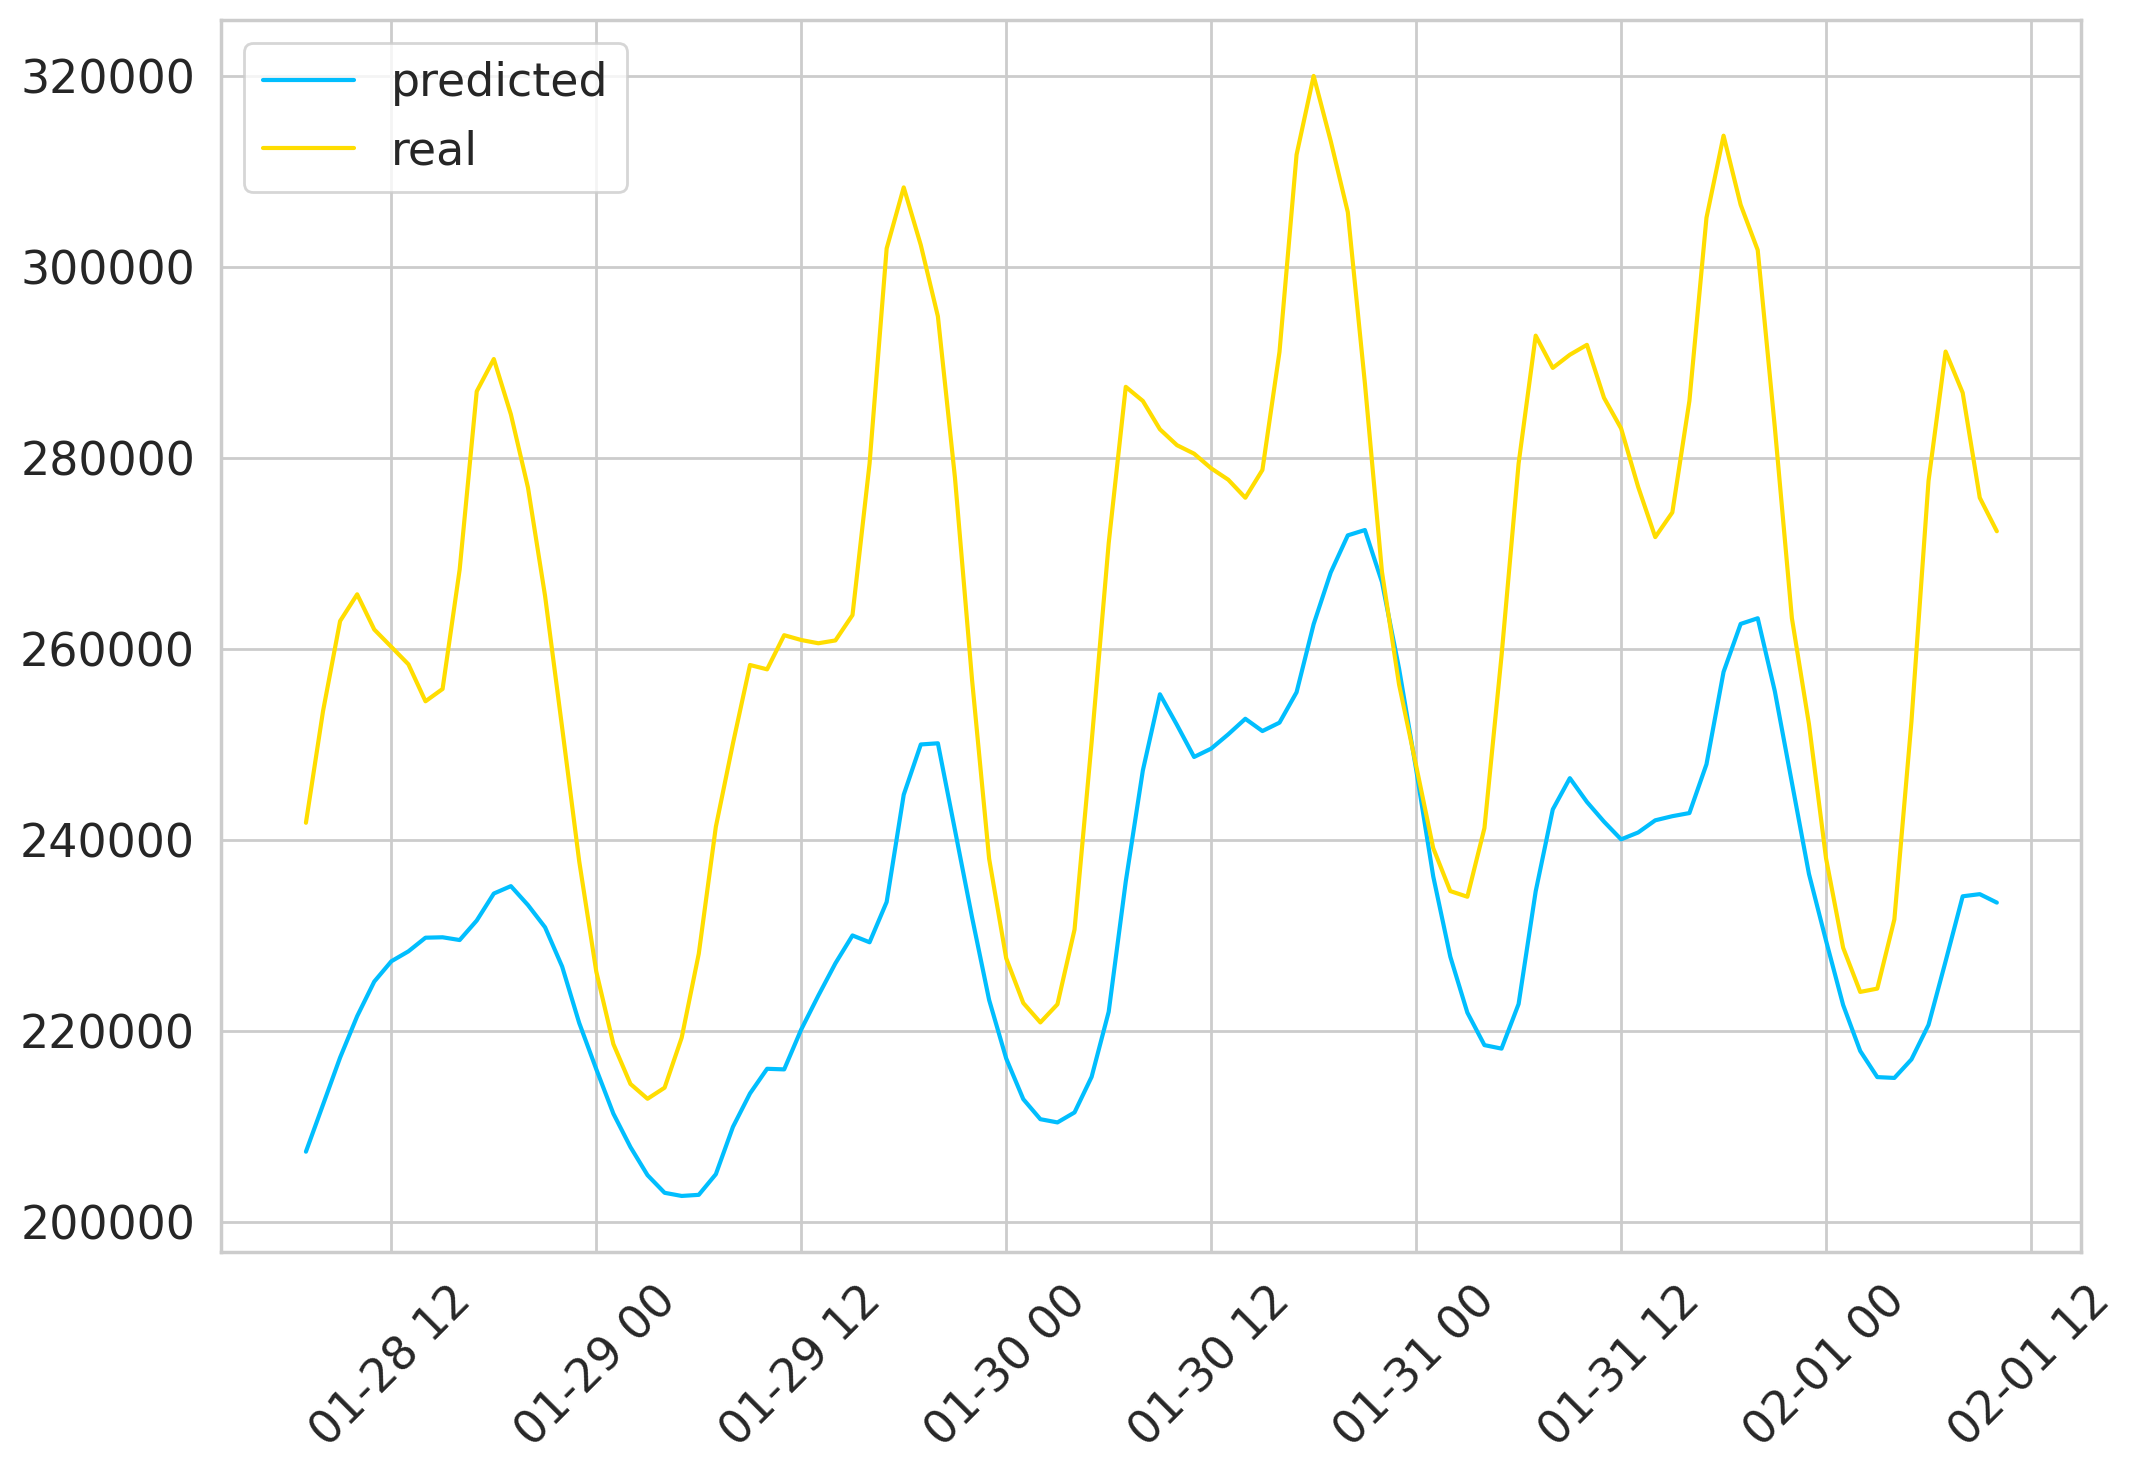

  0%|          | 0/58634 [00:00<?, ?it/s]

  0%|          | 0/58634 [00:00<?, ?it/s]

  0%|          | 0/52650 [00:00<?, ?it/s]

  0%|          | 0/5743 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | CNXLoadPredictionModel | 827 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
827 K     Trainable params
0         Non-tr

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 823: 'val_loss' reached 0.08935 (best 0.08935), saving model to '/content/checkpoints/best-checkpoint-v23.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1646: 'val_loss' reached 0.07268 (best 0.07268), saving model to '/content/checkpoints/best-checkpoint-v23.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 2469: 'val_loss' reached 0.05471 (best 0.05471), saving model to '/content/checkpoints/best-checkpoint-v23.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 3292: 'val_loss' reached 0.03644 (best 0.03644), saving model to '/content/checkpoints/best-checkpoint-v23.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 4115: 'val_loss' reached 0.02510 (best 0.02510), saving model to '/content/checkpoints/best-checkpoint-v23.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


  0%|          | 0/5743 [00:00<?, ?it/s]

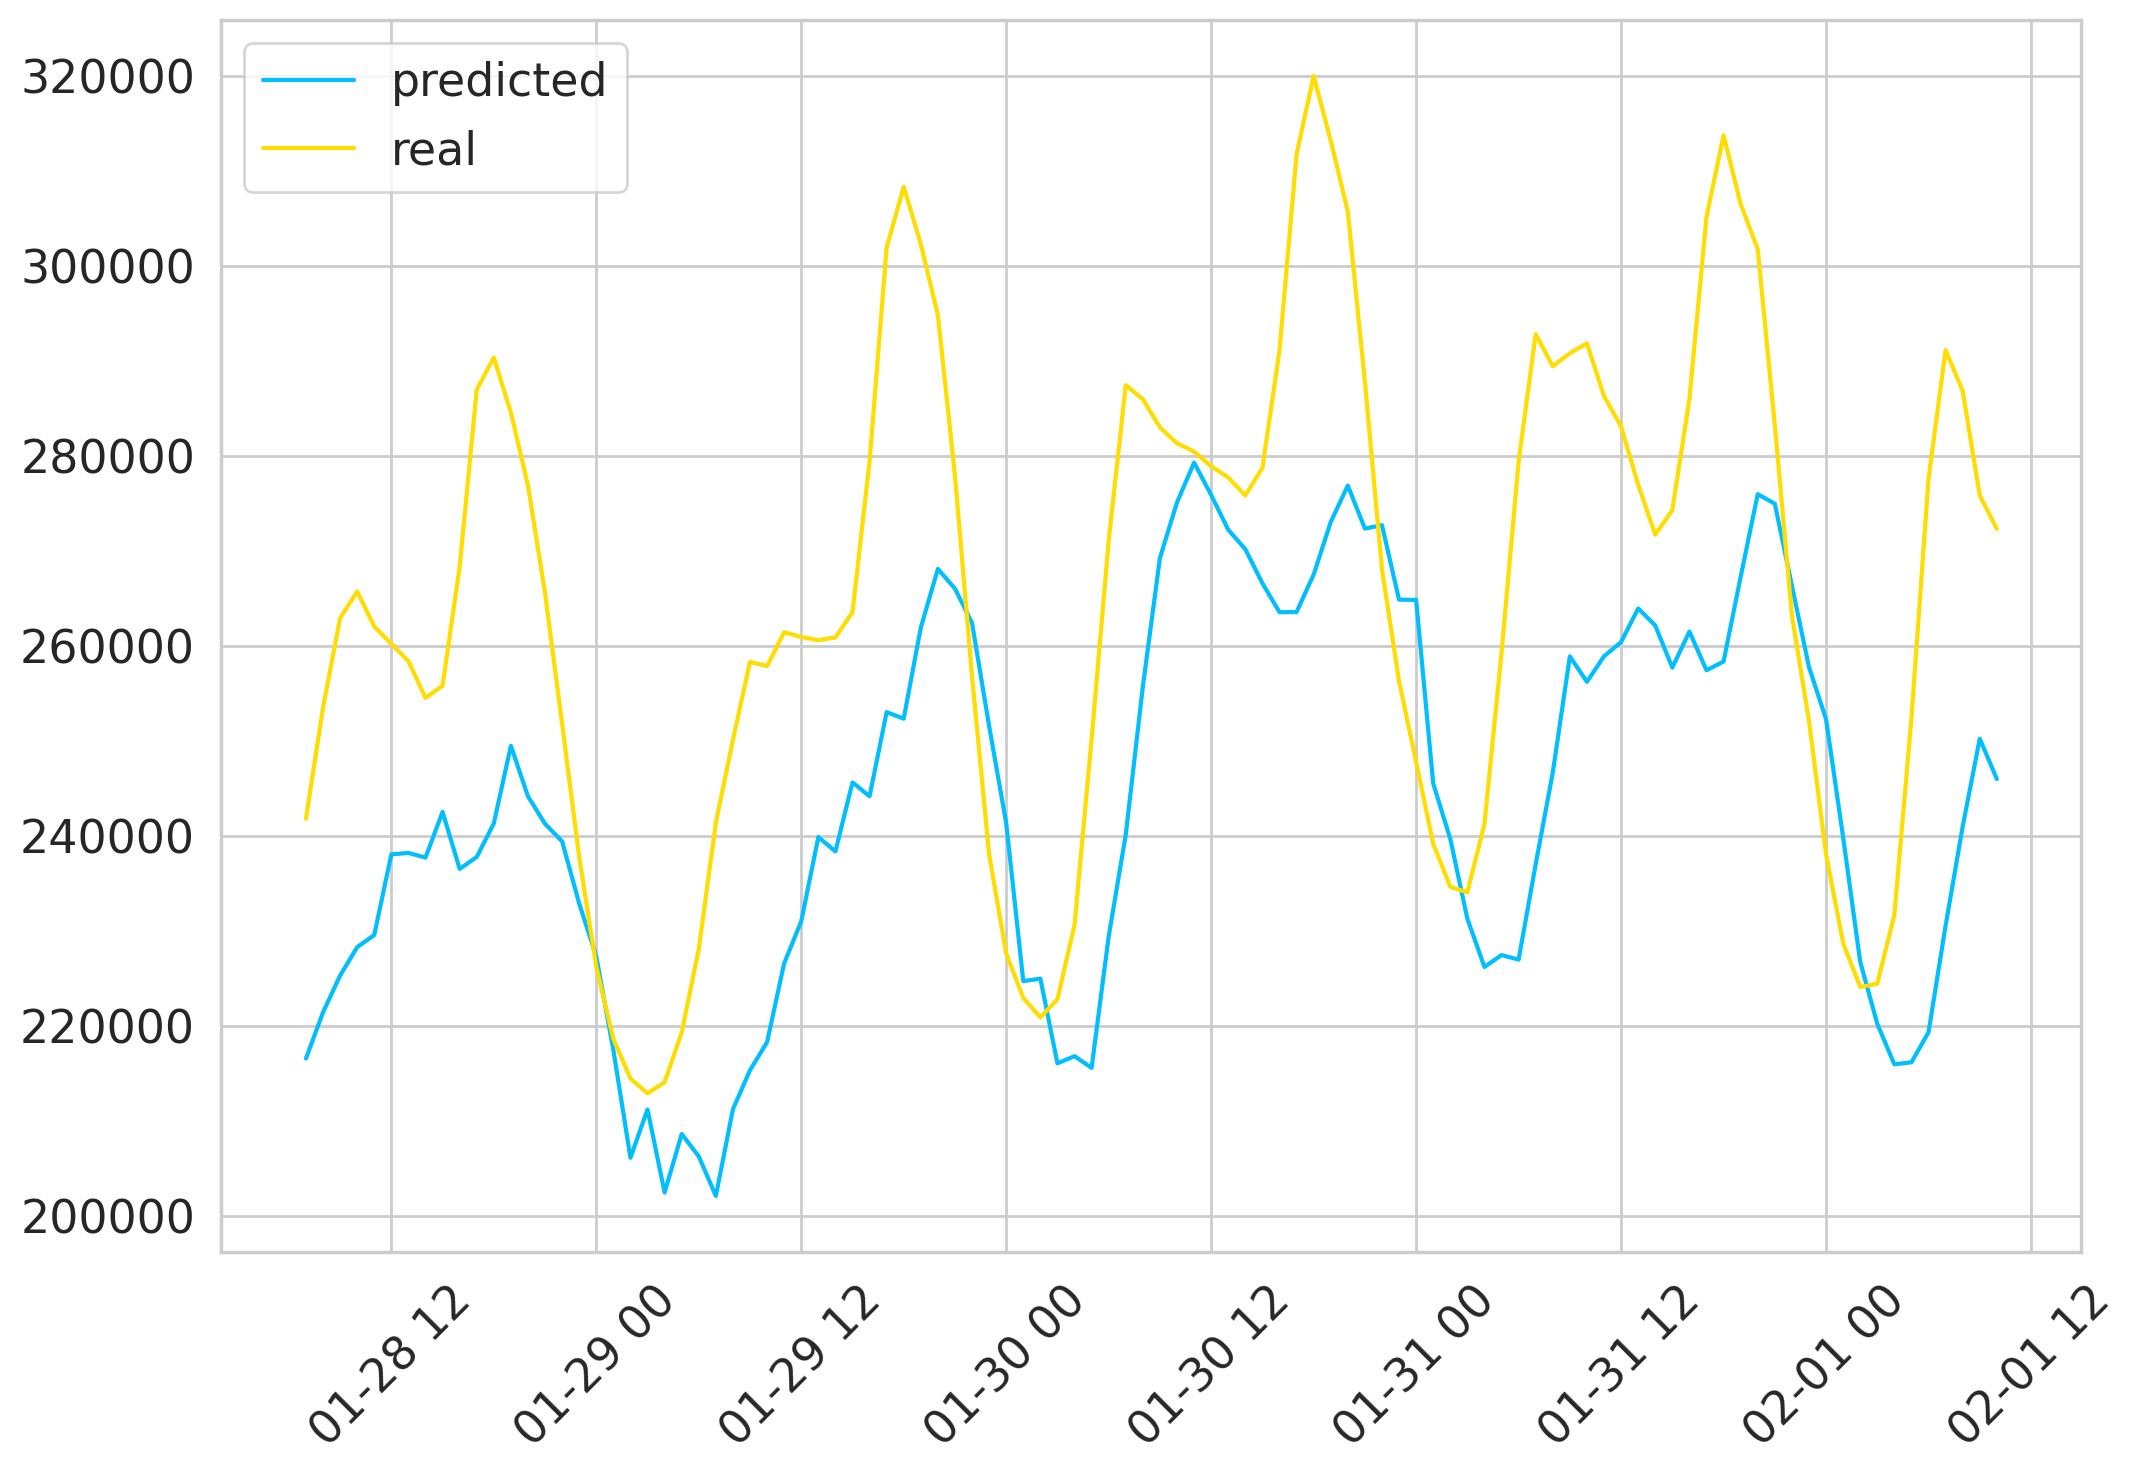

  0%|          | 0/58634 [00:00<?, ?it/s]

  0%|          | 0/58634 [00:00<?, ?it/s]

  0%|          | 0/52650 [00:00<?, ?it/s]

  0%|          | 0/5743 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | CNXLoadPredictionModel | 1.4 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.4 M     Trainable params
0         Non-tr

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 823: 'val_loss' reached 0.10069 (best 0.10069), saving model to '/content/checkpoints/best-checkpoint-v24.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1646: 'val_loss' reached 0.09244 (best 0.09244), saving model to '/content/checkpoints/best-checkpoint-v24.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 2469: 'val_loss' reached 0.08067 (best 0.08067), saving model to '/content/checkpoints/best-checkpoint-v24.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 3292: 'val_loss' reached 0.06090 (best 0.06090), saving model to '/content/checkpoints/best-checkpoint-v24.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 4115: 'val_loss' reached 0.03969 (best 0.03969), saving model to '/content/checkpoints/best-checkpoint-v24.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


  0%|          | 0/5743 [00:00<?, ?it/s]

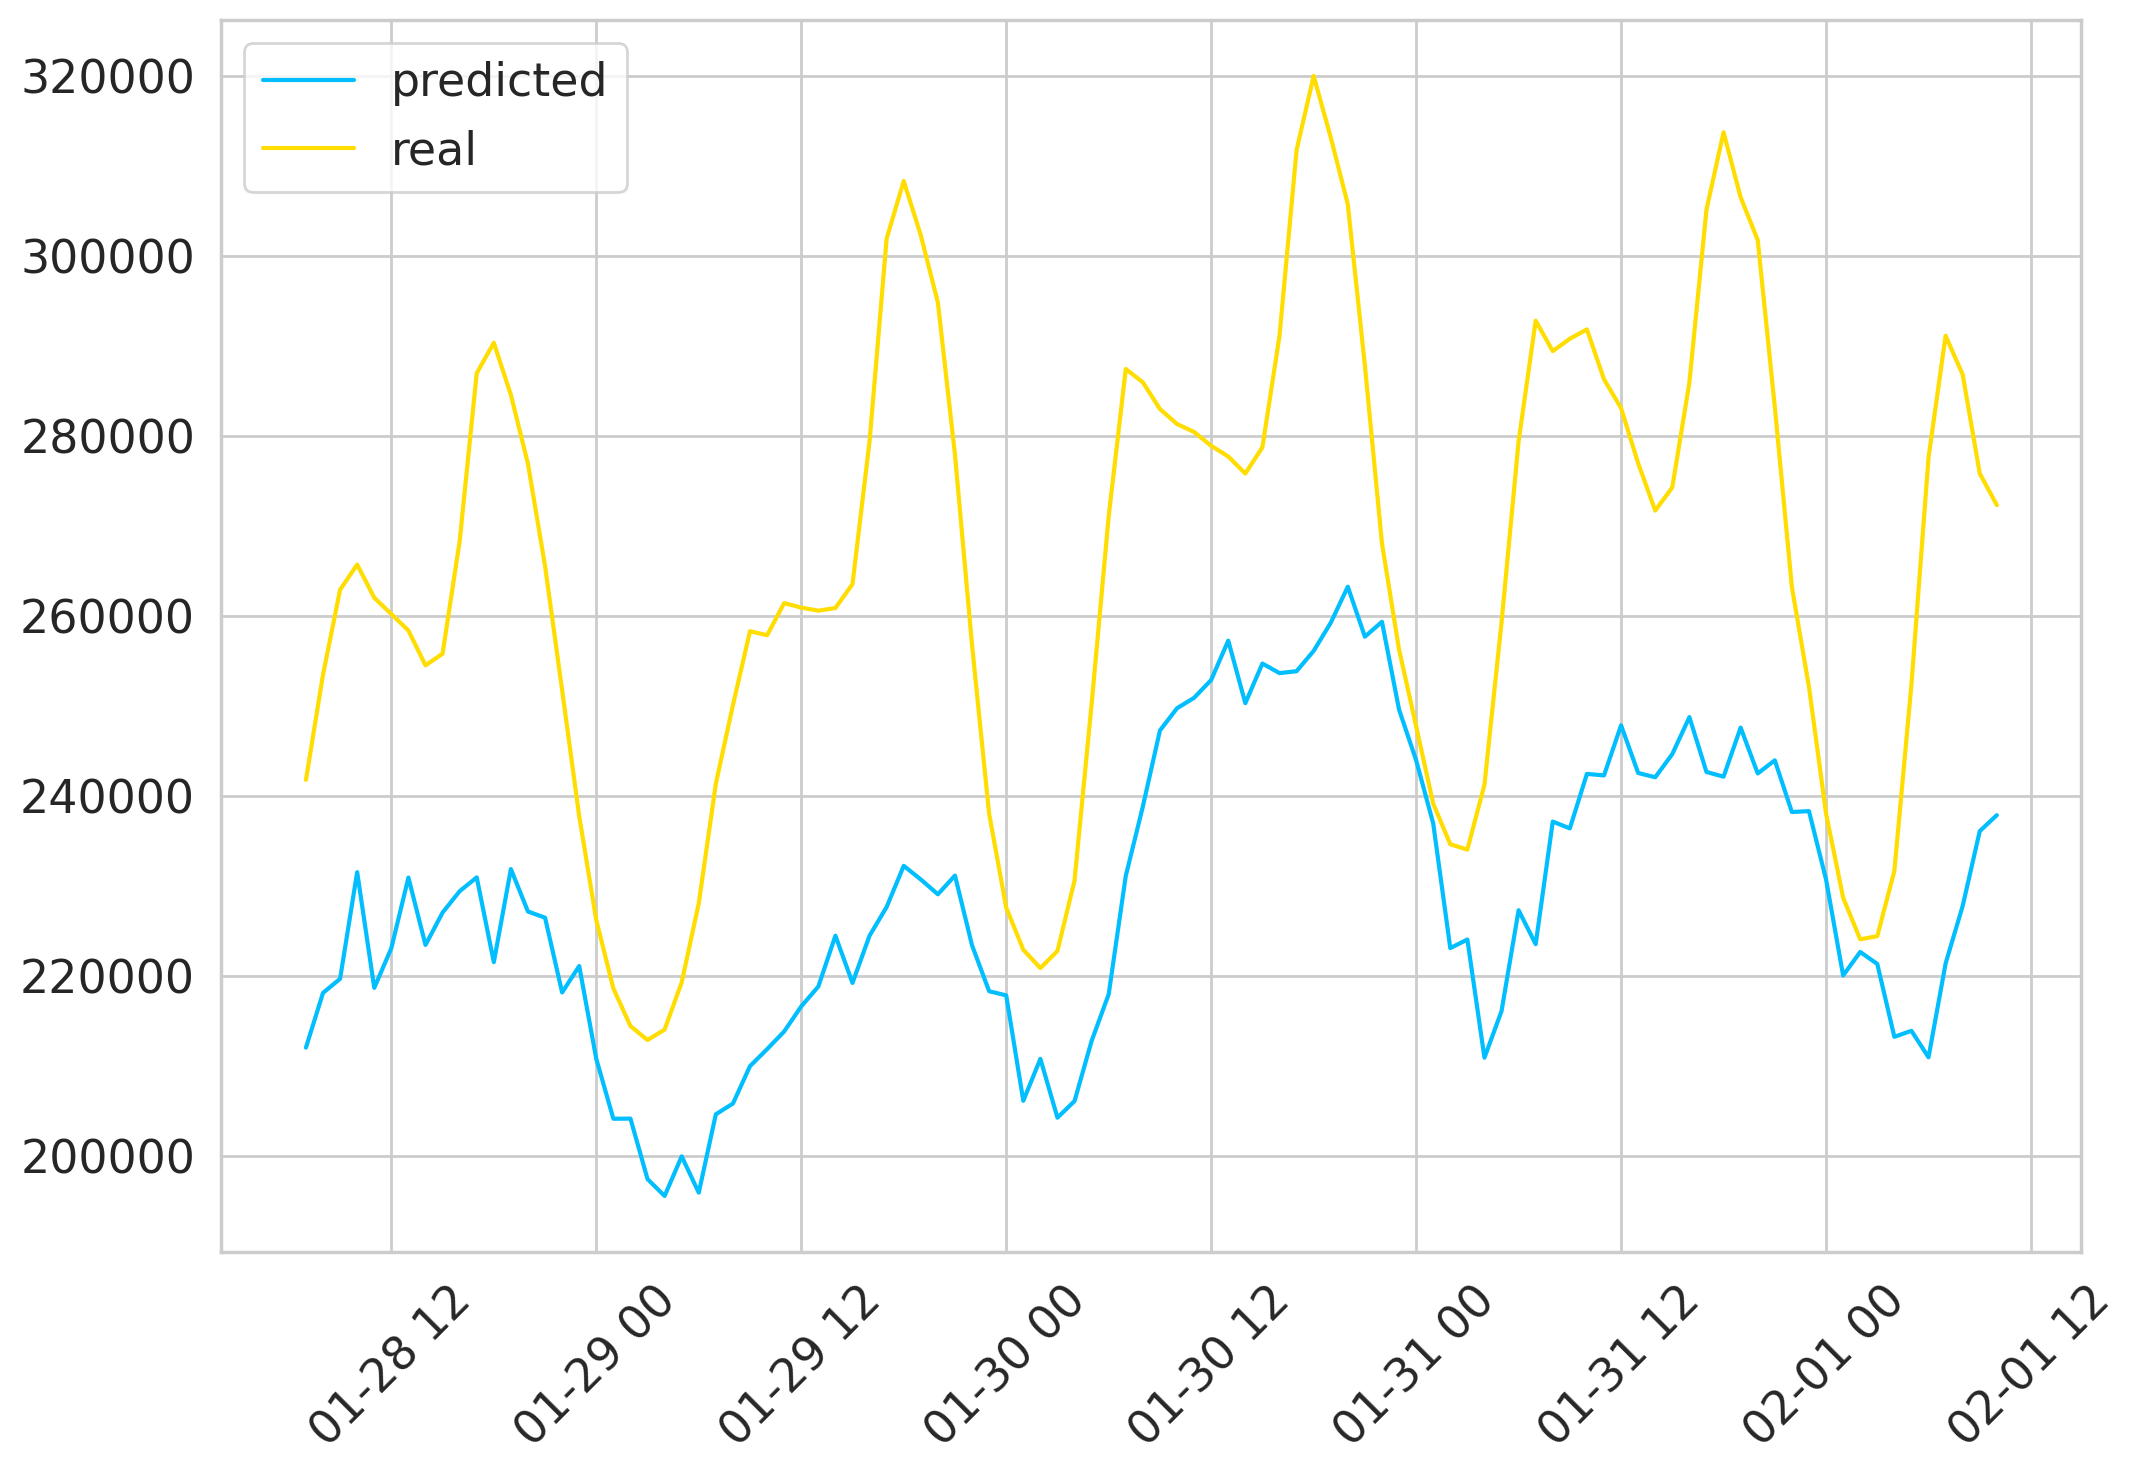

  0%|          | 0/58634 [00:00<?, ?it/s]

  0%|          | 0/58634 [00:00<?, ?it/s]

  0%|          | 0/52650 [00:00<?, ?it/s]

  0%|          | 0/5743 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | CNXLoadPredictionModel | 1.9 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
1.9 M     Trainable params
0         Non-tr

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 823: 'val_loss' reached 0.10730 (best 0.10730), saving model to '/content/checkpoints/best-checkpoint-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1646: 'val_loss' reached 0.10323 (best 0.10323), saving model to '/content/checkpoints/best-checkpoint-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 2469: 'val_loss' reached 0.09716 (best 0.09716), saving model to '/content/checkpoints/best-checkpoint-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 3292: 'val_loss' reached 0.08802 (best 0.08802), saving model to '/content/checkpoints/best-checkpoint-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 4115: 'val_loss' reached 0.06303 (best 0.06303), saving model to '/content/checkpoints/best-checkpoint-v25.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


  0%|          | 0/5743 [00:00<?, ?it/s]

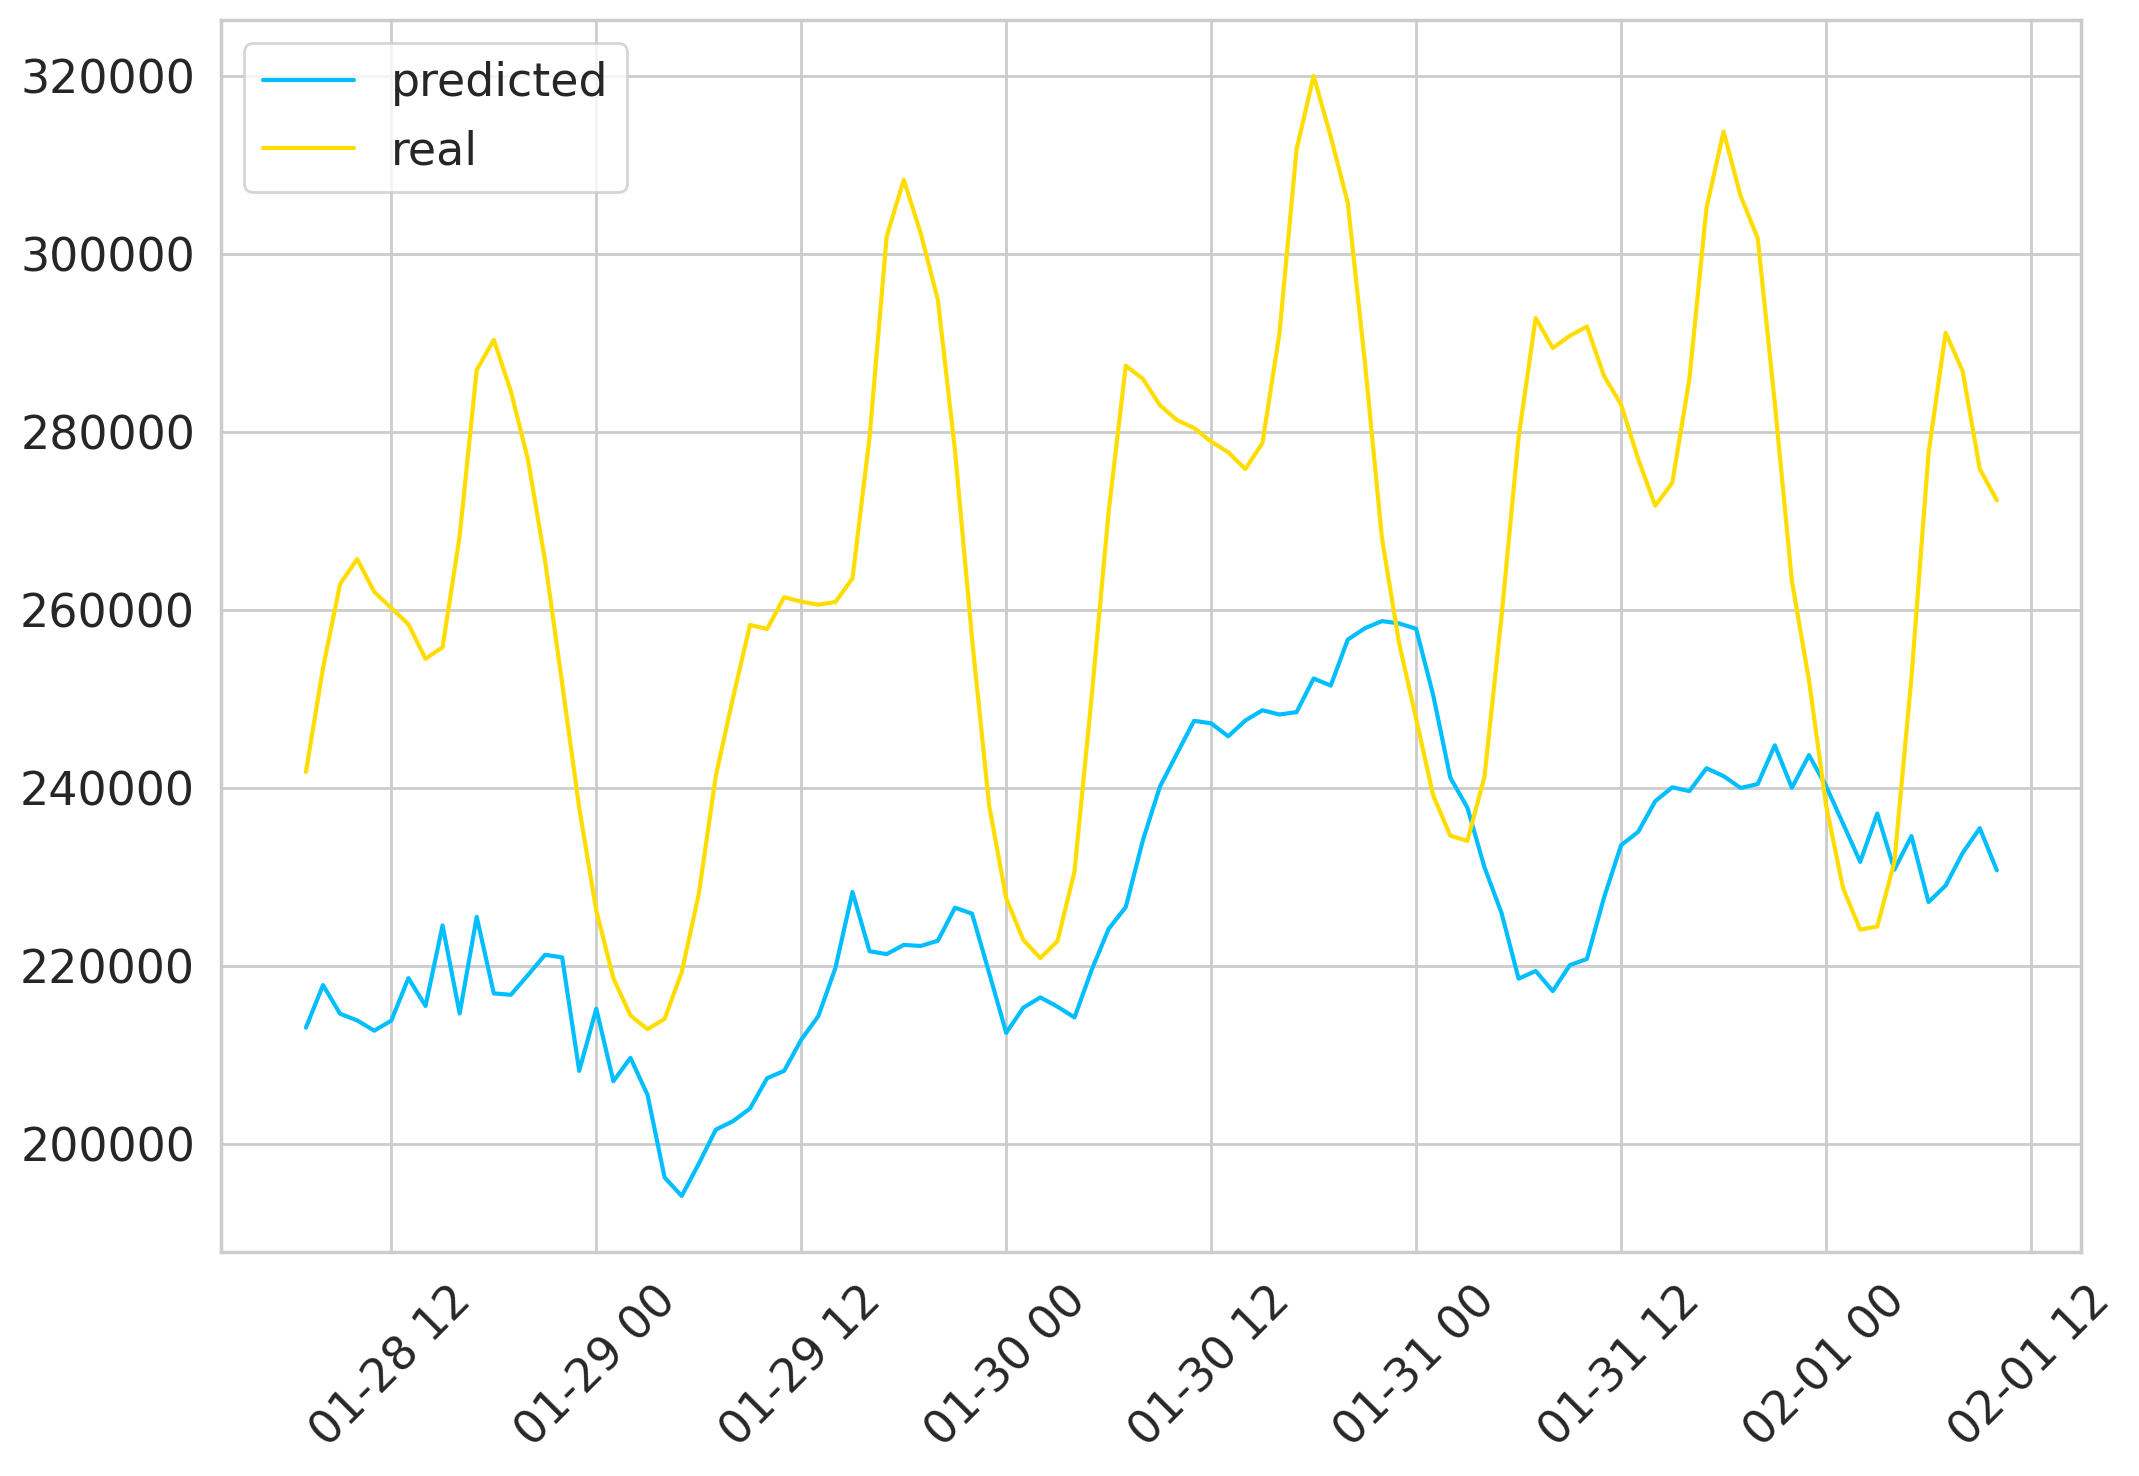

In [ ]:
seq_length_list = [80, 100, 120, 140]
num_layers_list = [1, 2, 3, 4]

for i in num_layers_list:

  feature_df, train_df, train_sequence, test_df, test_sequence, data_module, scaler = \
  make_model_input_data(df=df, seq_length=120, batch_size=64)

  predictions, labels = run_LSTM(
    train_df = train_df,
    train_sequences = train_sequence,
    test_df = test_df,
    test_sequences = test_sequence,
    data_module = data_module,
    n_layers = i,
    num_epochs = 5
  )

  draw_result(predictions, labels, seq_length=120)
